
# ARSENL Backscatter Experiments

Grant Kirchhoff
10-08-2024
University of Colorado Boulder

Fit the photon arrival rate to simulated sigmoid profiles using different acquisition resolution to evaluate the impact of digitization error on the fit quality. 

IMPORTANT: Set parameters and settings first

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr
import sys
from pathlib import Path
import matplotlib as mpl

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)
    
import fit_polynomial_utils_cloud as fit
import data_organize as dorg

mpl.rcParams["figure.facecolor"] = 'w'

### First, load and plot data

In [3]:
# Constants
c = 299792458  # [m/s] speed of light

# Parameters
home = str(Path.home())
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Digitization Tests', 'Sims', 'saved_sims')
# load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\Digitization Tests\Sims\saved_sims'

fname = r'nshot1.00E+07_A1.00E+07_alpha1.00E+09_mu5e-08_sigTrue.nc'

ds = xr.open_dataset(os.path.join(load_dir, fname))

In [3]:
phot_events = ds.true_time_tag.values
dt_sim = ds.dt_sim.values  # [s]
t_sim_bins = ds.t_sim_bins.values  # [s]
Nshot_tot = ds.sync_index.values[-1] + 1
det_events = ds.time_tag.values
photon_rate_arr = ds.photon_rate_arr.values
dtime = ds.dtime.values  # [s] deadtime

t_sim = t_sim_bins[:-1]  # [s]

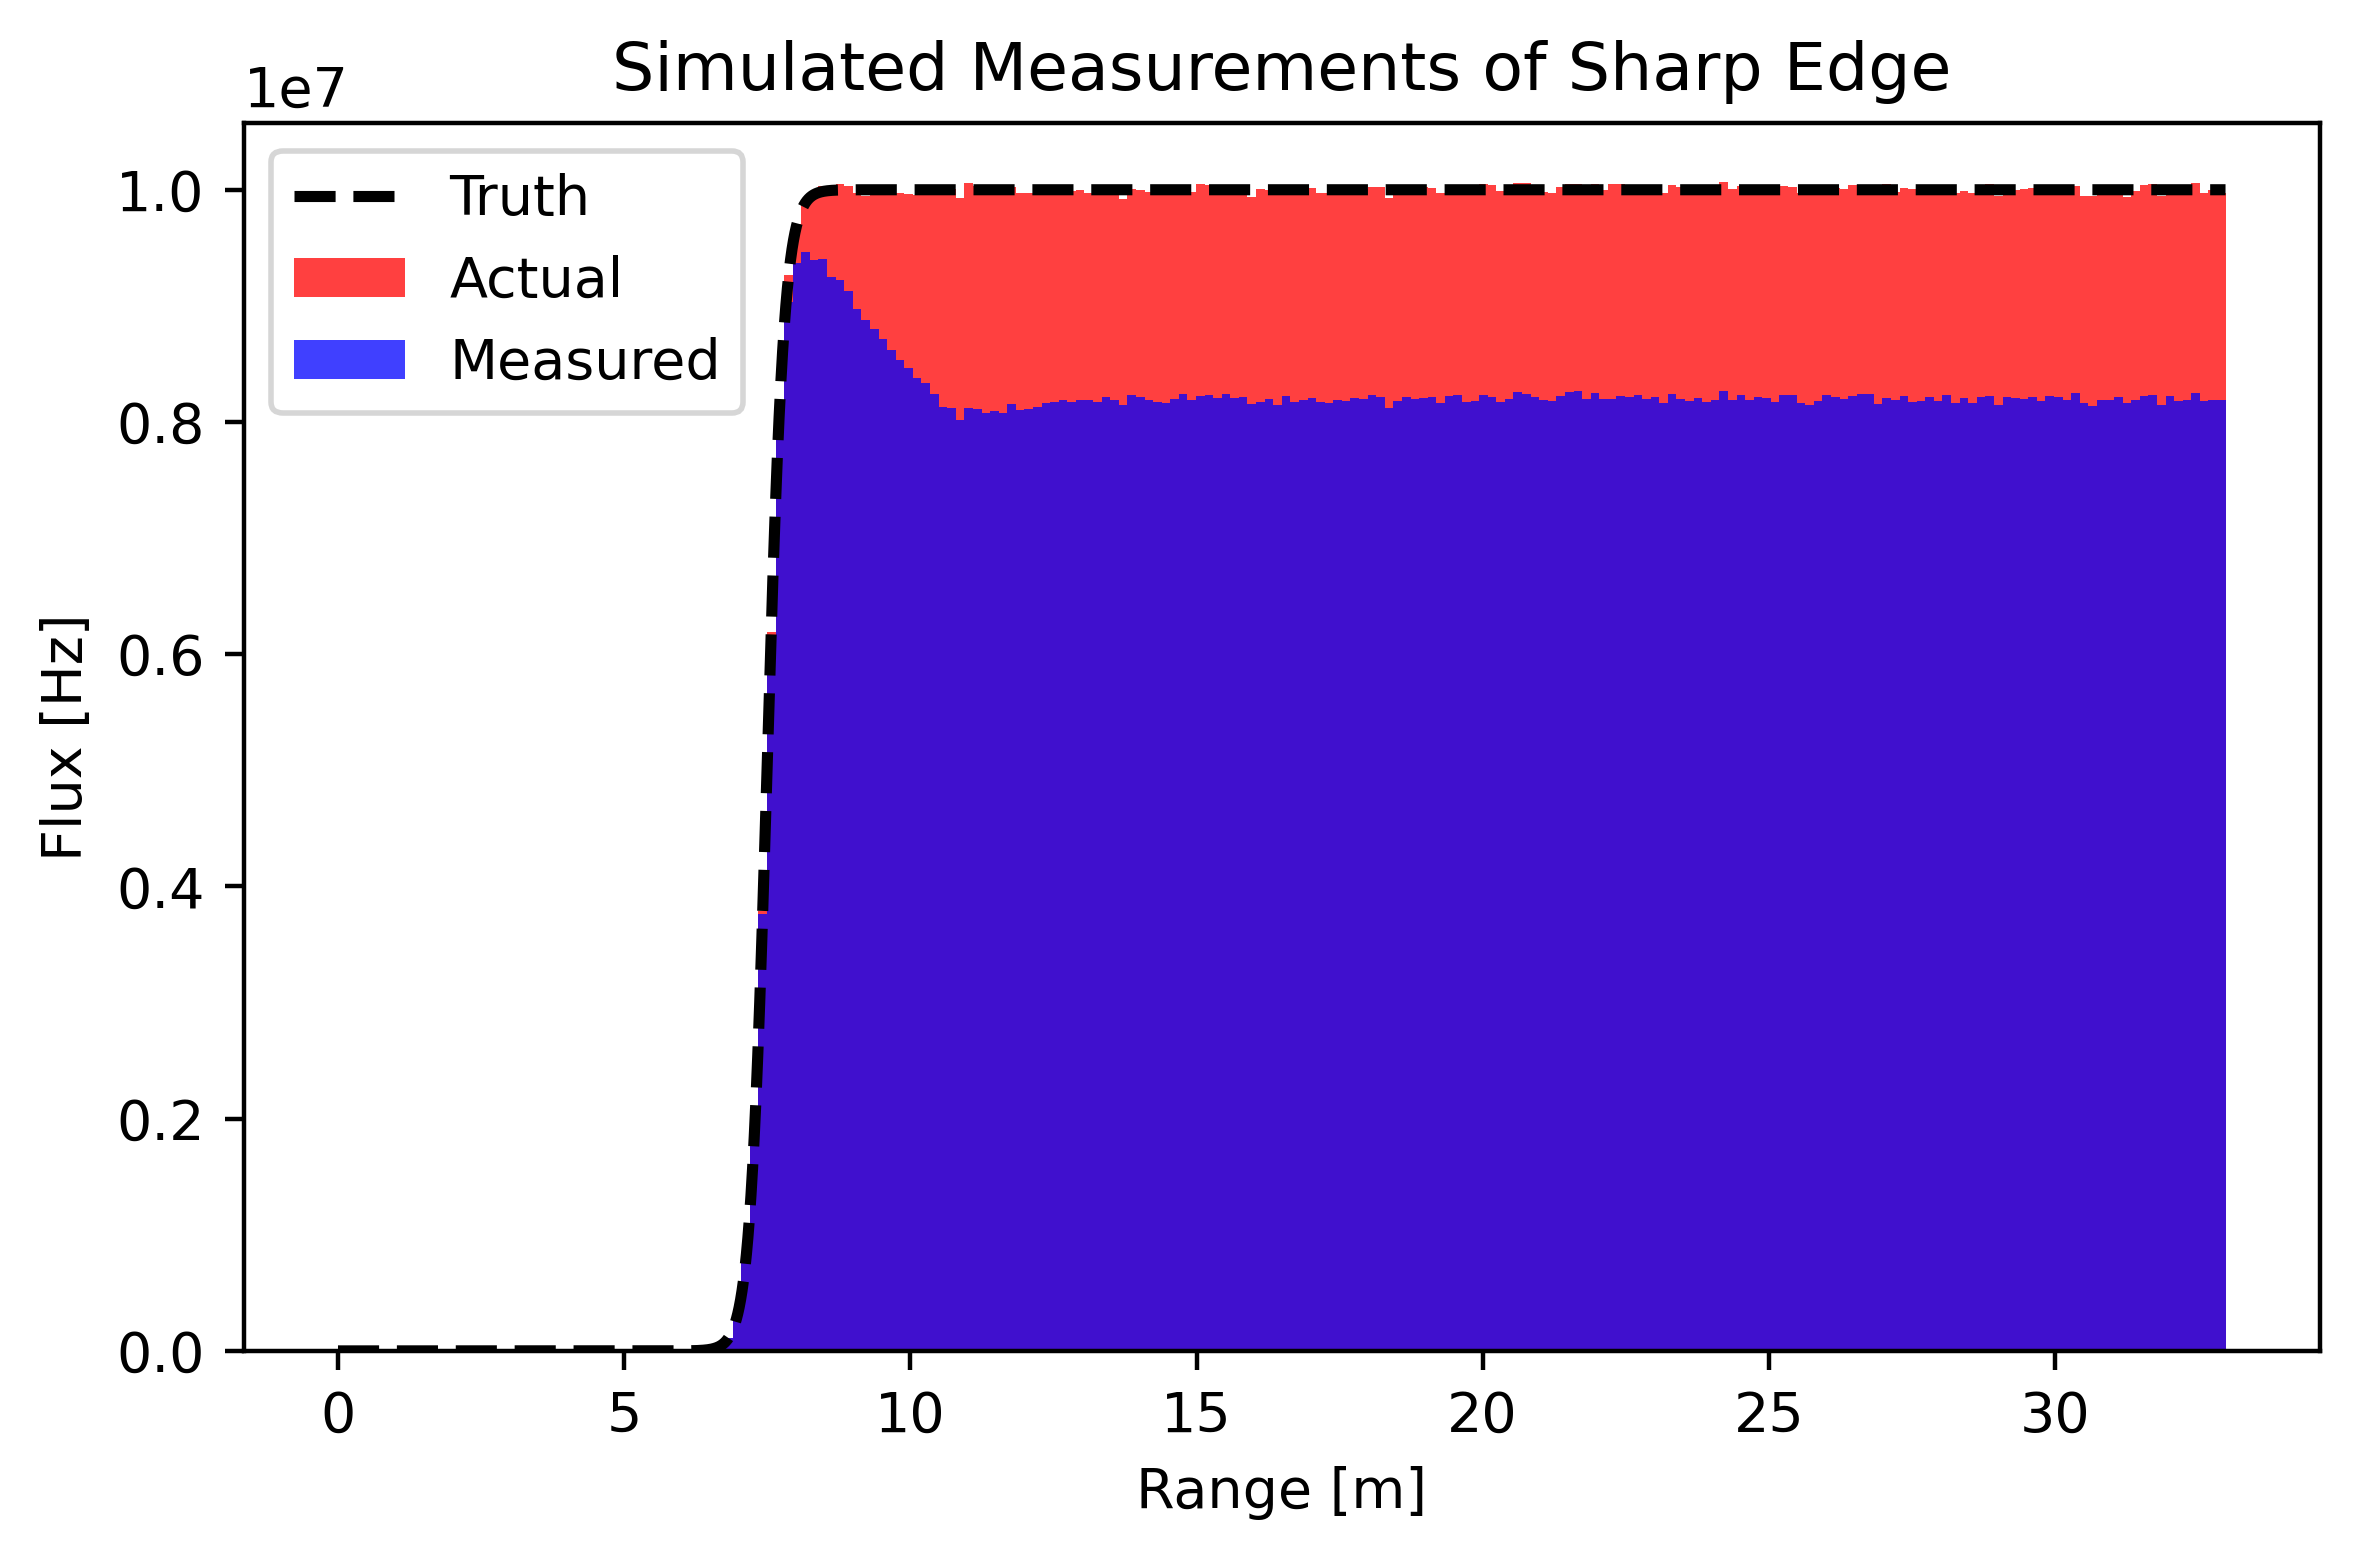

In [9]:
bin_avg = 100  # integration factor (increase bin sizes)

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

n, bins = np.histogram((np.array(phot_events)*dt_sim), bins=t_sim_bins[::bin_avg])
binwidth = np.diff(bins)[0]
N = n / binwidth / Nshot_tot  # [Hz]
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='r', alpha=0.75, label='Actual')

tof = (np.array(det_events)*dt_sim)
n, bins = np.histogram(tof, bins=t_sim_bins[::bin_avg])
N = n / binwidth / Nshot_tot  # [Hz] Scaling counts to arrival rate
ax.bar(center*c/2, N, align='center', width=binwidth*c/2, color='b', alpha=0.75, label='Measured')

ax.plot(t_sim*c/2, photon_rate_arr, 'k--', alpha=1.0, linewidth=2, label='Truth')

ax.set_ylabel('Flux [Hz]')
ax.set_xlabel('Range [m]')
ax.set_title('Simulated Measurements of Sharp Edge')
# ax.set_yscale('log')
plt.tight_layout()
plt.legend()
plt.show()

### Fitting Routine
Using the histogram form of the deadtime loss function. Since we know the shape of the profile is a sigmoid:
$$\lambda(t)=sig(A,\alpha,\mu,b,t)=\frac{A}{1+\exp[-\alpha(t-\mu)]}+b$$
where $t$ is time (or range), $A$ is the peak flux, $\alpha$ is the steepness of the step, $\mu$ is the offset, and $b$ is the background flux. The loss function will follow:
$$\mathcal{L}_D\left(\boldsymbol{\lambda};\left\lbrace\lbrace T_n=t'_n\rbrace^{N_i}_{n=1}\right\rbrace^{\mathcal{N}}_{i=1}\right)=\sum_{m=1}^{M}\left(\mathcal{N}\lambda_mZ_m\Delta t-Y_m\ln\lambda_m\right)$$
where $\mathcal{L}_D$ is the deadtime loss function, $\boldsymbol{\lambda}$ is the flux profile, $\boldsymbol{T}$ is the timestamp random variable, $\boldsymbol{t}$ is the realization of those timestamps, $\boldsymbol{N}$ is the total number of counts per shot, $\mathcal{N}$ is the total number of shots, $M$ is the total number of bins in the histogram, $\Delta t$ is the acquisition resolution, and
$$Z_m\triangleq\frac{1}{\mathcal{N}}\sum_{i=1}^{\mathcal{N}}z_{m,i}$$
where $\boldsymbol{z}$ is the "single-shot active-fraction histogram" (see paper) and
$$Y_m\triangleq\sum_{i=1}^{\mathcal{N}}y_{m,i}$$ 
is the photon-counting histogram, where $\boldsymbol{y}$ is the single-shot photon-counting histogram (see paper). The flux estimate $\tilde{\boldsymbol{\lambda}}$ is found by minimizing the loss function
$$\tilde{\boldsymbol{\lambda}}=\mathrm{argmin}_{\lambda}\mathcal{L}_D$$
This will allow us to solve for the parameters $A$, $\alpha$, $\mu$, and $b$. By using educated guesses for these values as initial values, it should (hopefully) avoid local minima, e.g., $b<<A$.

In [10]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()
        self.log_A = torch.nn.Parameter(np.log(1e6)*torch.ones(()))    # [Hz] Sigmoid amplitude
        self.log_mu = torch.nn.Parameter(np.log(10e-9)*torch.ones(()))  # [s] Sigmoid shift
        self.log_alpha = torch.nn.Parameter(np.log(5e8)*torch.ones(()))  # [1/s] Sigmoid steepness
        self.log_b = torch.nn.Parameter(np.log(1)*torch.ones(()))    # [Hz] background  
#         self.b = 10
#         self.mu = 50e-9

    def forward(self, t_intgrl):
        """
        Forward model the profile for input time t.
        Also return the integral.
        """
        # calculate all the actual fit parameters
        A = torch.exp(self.log_A)  # [Hz]
#         mu = self.mu  # [s]
        mu = torch.exp(self.log_mu)  # [s]
        b = torch.exp(self.log_b)  # [Hz]
        alpha = torch.exp(self.log_alpha)  # [1/s]
        
        model_out = A/(1+torch.exp(-alpha*(t_intgrl-mu))) + b  # [Hz]
            
        return model_out

In [11]:
def pois_loss_discrete(pred_fit, active_ratio_hst, dt, Y, Nshots):
    """
    Non-homogenous Poisson point process loss function - discrete form
    """
    loss = torch.sum(Nshots*pred_fit*active_ratio_hst*dt - Y*torch.log(pred_fit))

    return loss

In [12]:
# optimization parameters

rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 2500     # maximum number of iterations/epochs
learning_rate = 1e-2  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In [13]:
t_min = t_sim[0]  # [s]
t_max = t_sim[-1]  # [s]
window_bnd = [t_min, t_max]  # [s]
max_lsr_num = int(1e4)
exclude_shots = True
flight_time, n_shots, t_det_lst = dorg.data_organize(dt_sim, load_dir, fname, window_bnd, max_lsr_num-1, exclude_shots)
t_phot_fit_tnsr = torch.tensor(flight_time.values)

# calculate active fraction histogram
dsamp = 500
intgrl_N = int(len(t_sim_bins)/dsamp)  # number of bins in integral. I usually set this to the number of bins in the histogram for consistency
deadtime = dtime  # [s] 

active_ratio_hst, AF_bin_edges = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
t_bins = AF_bin_edges[:-1] + 0.5*np.diff(AF_bin_edges)[0]
binwidth = np.diff(AF_bin_edges)[0]

Y = torch.from_numpy(np.histogram(t_phot_fit_tnsr.detach().numpy(), bins=AF_bin_edges)[0])

# t_intgrl = torch.arange(t_min, t_max, binwidth)[:-1]  # [s]
t_intgrl = torch.tensor(t_bins)  # [s]

print('Acquisition binwidth: {:.2E}'.format(binwidth))

Acquisition binwidth: 5.00E-09


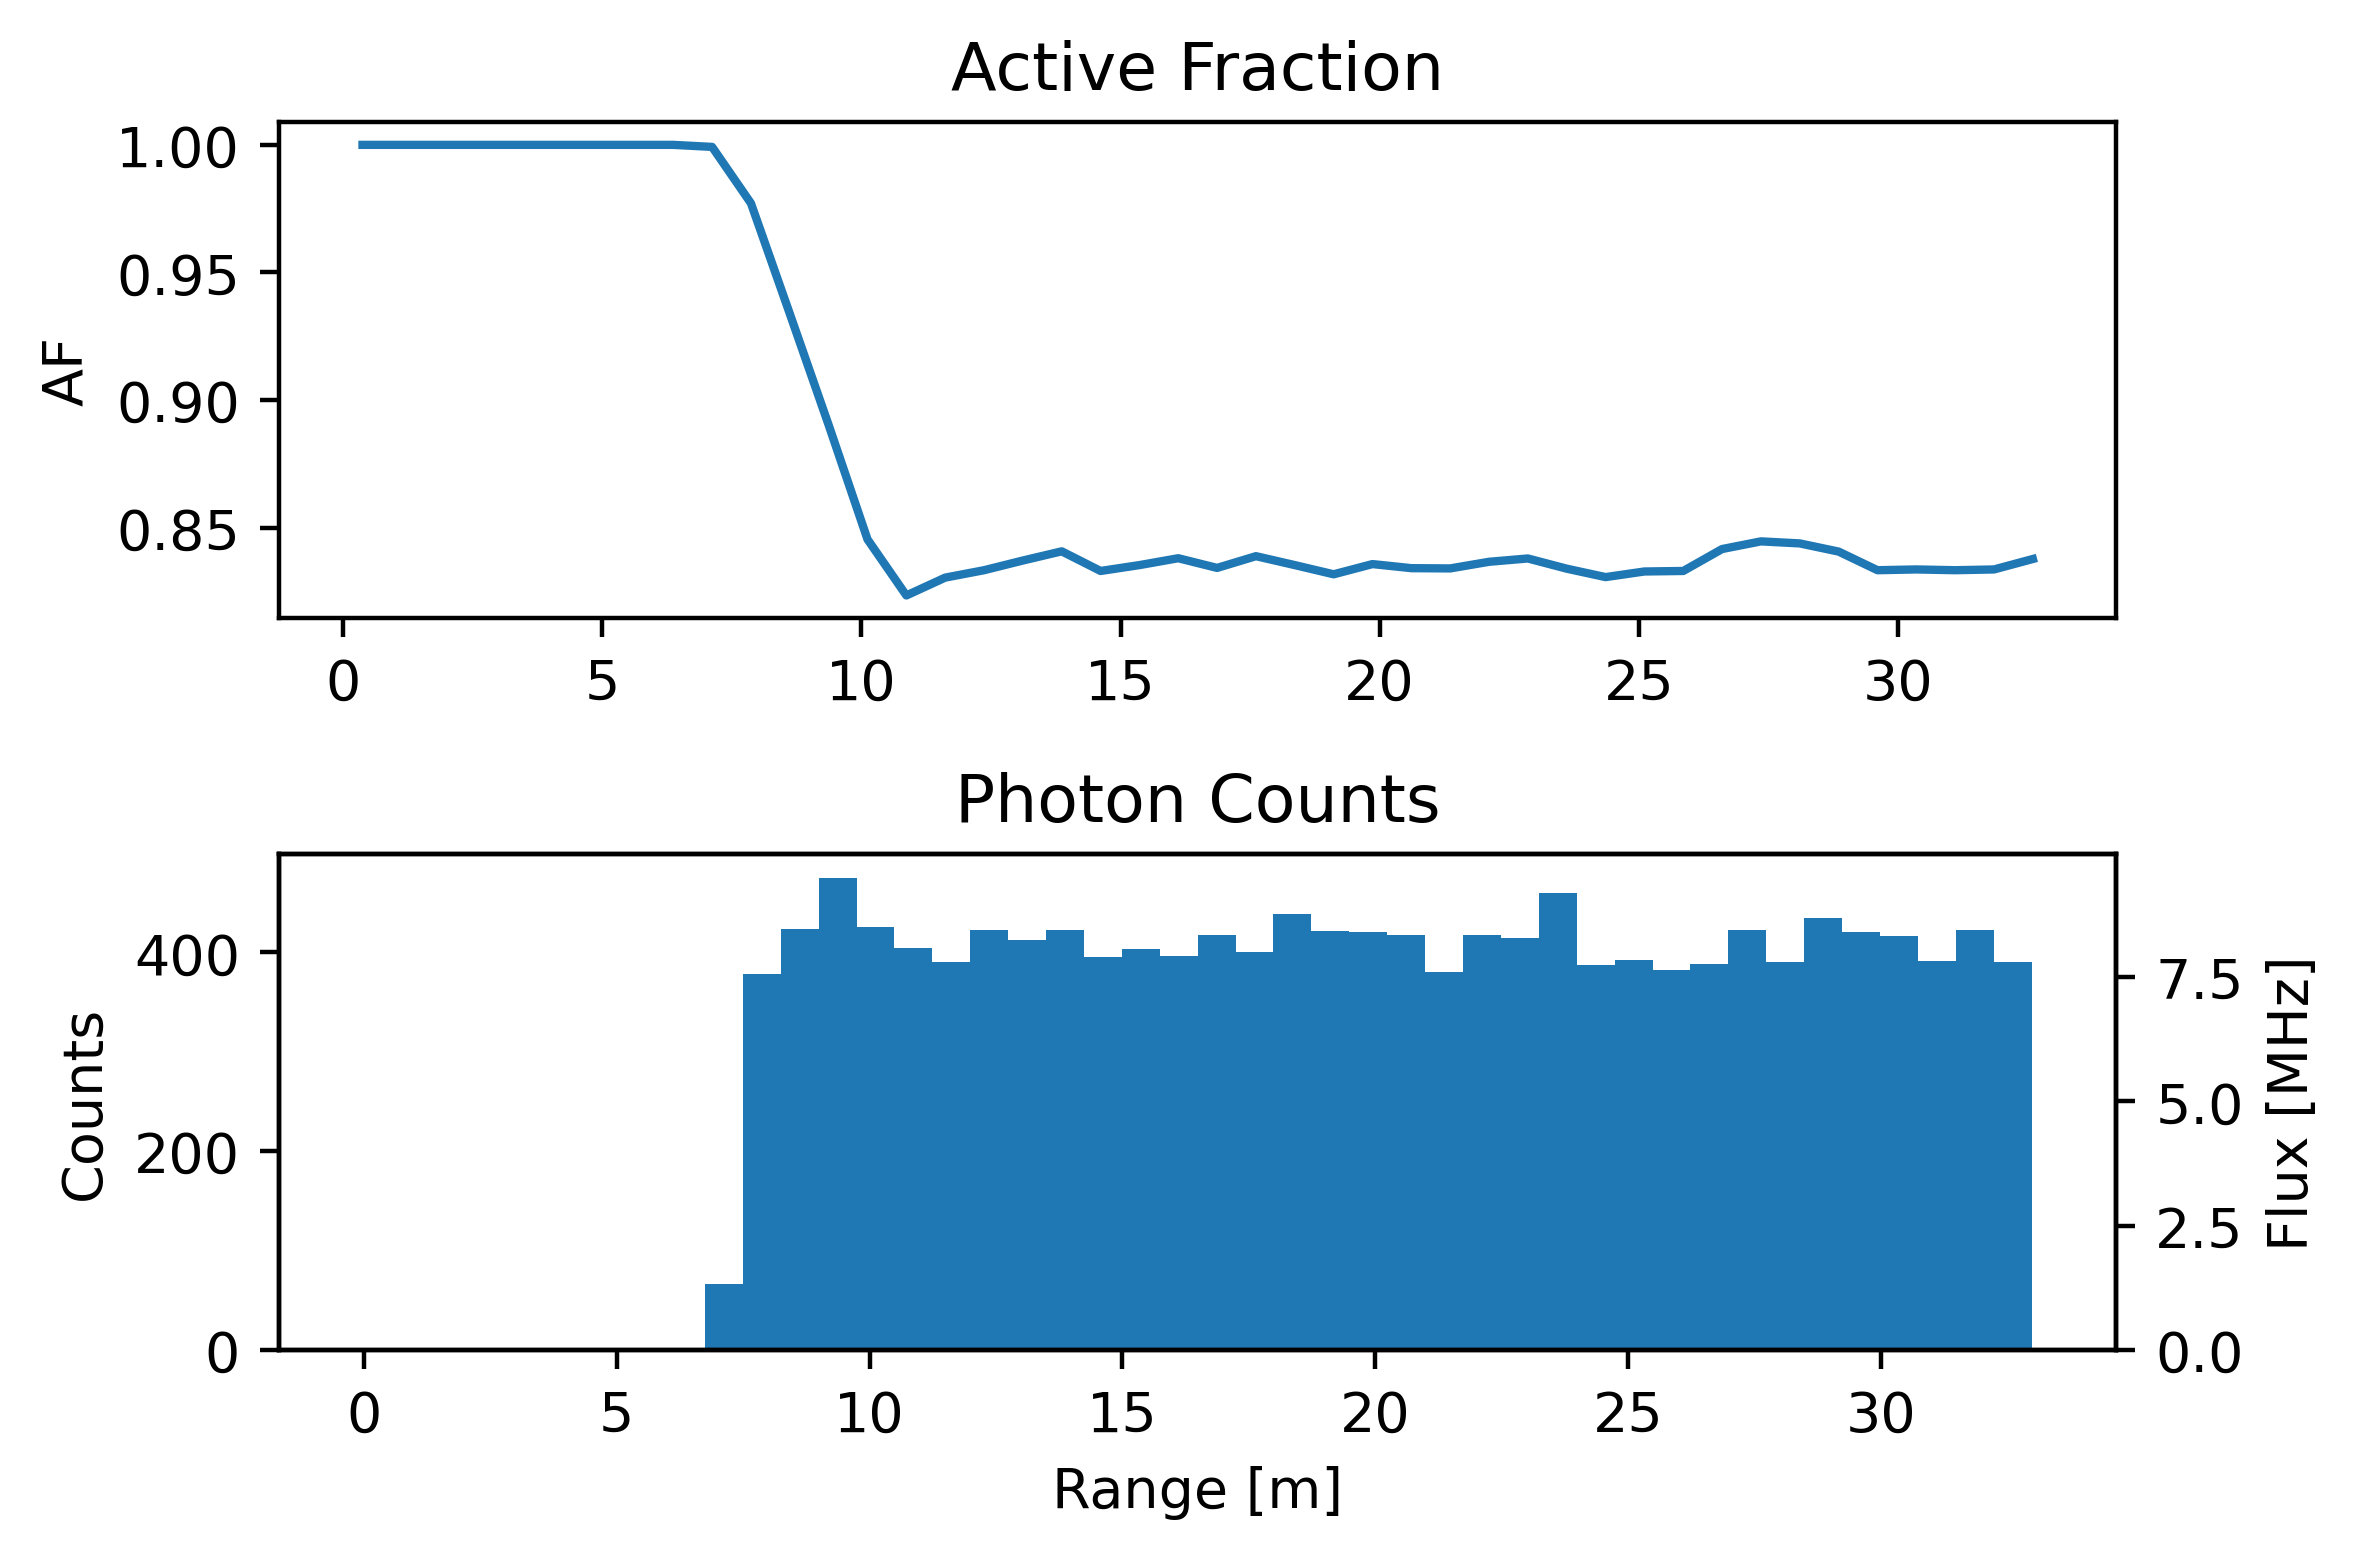

In [14]:
fig = plt.figure(dpi=400)
ax1 = fig.add_subplot(211)
ax1.plot(t_bins*c/2, active_ratio_hst)
ax1.set_ylabel('AF')
ax1.set_title('Active Fraction')
ax2 = fig.add_subplot(212)
ax2.bar(t_bins*c/2, Y, width=binwidth*c/2, align='center')
ax2.set_xlabel('Range [m]')
ax2.set_ylabel('Counts')
ax2.set_title('Photon Counts')
ax3 = ax2.twinx()
ax3.bar(t_bins*c/2, Y/binwidth/n_shots/1e6, alpha=0)
ax3.set_ylabel('Flux [MHz]')
plt.tight_layout()
plt.show()

In [15]:
# initialize for fit loop
fit_model = Fit_Pulse()
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

dt_acq = torch.diff(t_intgrl)[0]

# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss_discrete

In [16]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    fit_model.train()
    pred = fit_model(t_intgrl)
    loss = loss_fn(pred, active_ratio_hst, dt_acq, Y, n_shots)
    
#     loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

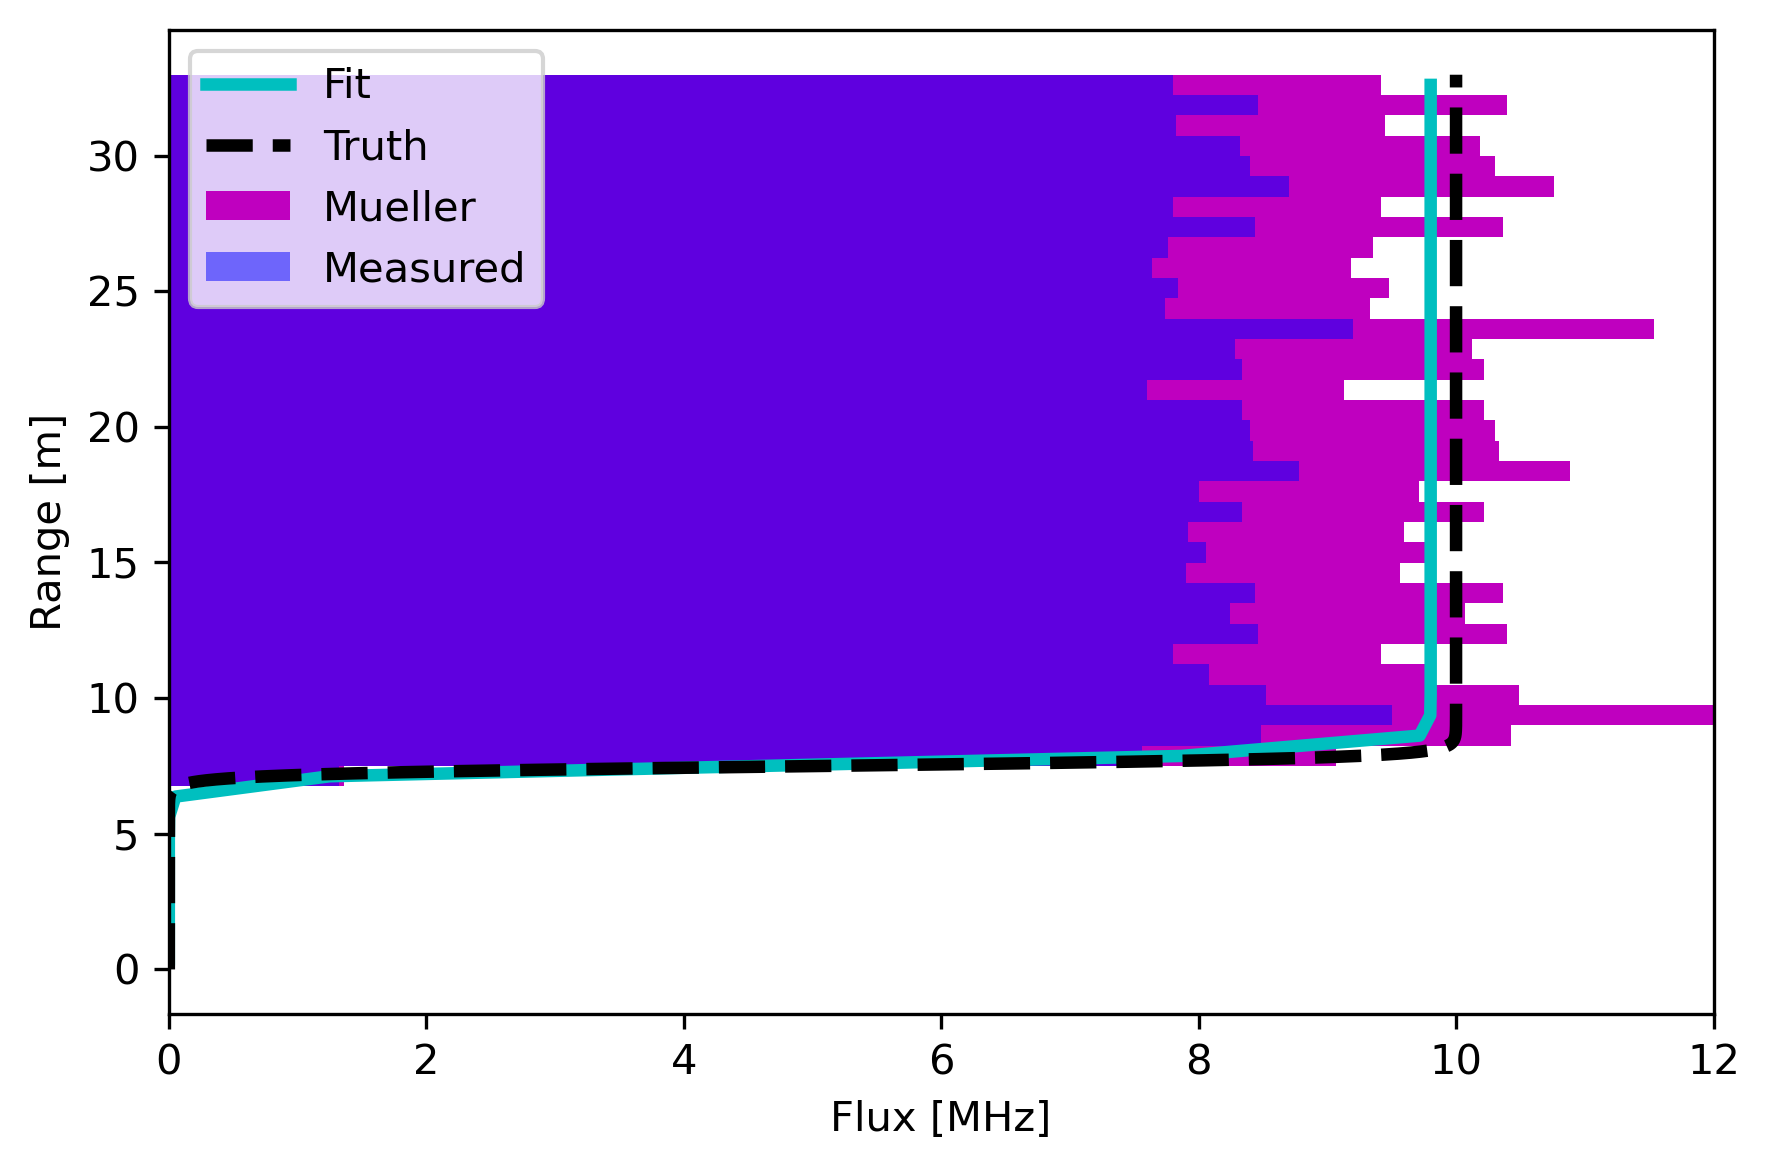

In [17]:
bin_avg = dsamp  # integration factor (increase bin sizes)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)

# n, bins = np.histogram((np.array(phot_events)*dt_sim), bins=t_sim_bins[::bin_avg])
# binwidth = np.diff(bins)[0]
# N = n / binwidth / Nshot_tot  # [Hz]
# center = 0.5 * (bins[:-1] + bins[1:])
# ax.barh(center*c/2, N/1e6, align='center', height=binwidth*c/2, color='r', alpha=0.5, label='Actual')

# tof = (np.array(det_events)*dt_sim)
n, bins = np.histogram(flight_time, bins=AF_bin_edges)
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.barh(center*c/2, N/(1-N*dtime)/1e6, align='center', height=binwidth*c/2, color='m', alpha=1, label='Mueller')
ax.barh(center*c/2, N/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.5, label='Measured')

ax.plot(pred.detach().numpy()/1e6, center*c/2, 'c', linewidth=3, label='Fit')

ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_xlim([0, 12])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
print('Final alpha: {:.2E}'.format(torch.exp(fit_model.log_alpha)))
print('Final A: {:.2E}'.format(torch.exp(fit_model.log_A)))
print('Final b: {:.2E}'.format(torch.exp(fit_model.log_b)))
print('Final mu: {:.2E}'.format(torch.exp(fit_model.log_mu)))

Final alpha: 6.65E+08
Final A: 9.80E+06
Final b: 2.43E-01
Final mu: 5.04E-08


### Instantaneous Deadtime Correction

If I don't do any type of fitting, then I can apply the instantaneous correction, which is found by minimizing the deadtime loss function for each bin $m$ individually:
$$\frac{\partial}{\partial\lambda_m}\left(\mathcal{N}Z_m\Delta t \lambda_m-Y_m\ln\lambda_m\right)=\mathcal{N}Z_m\Delta t-Y_m\frac{1}{\lambda_m}=0$$
$$\hat{\lambda}_m=\frac{Y_m}{\mathcal{N}\Delta tZ_m}$$
for $Z_m\neq0$.

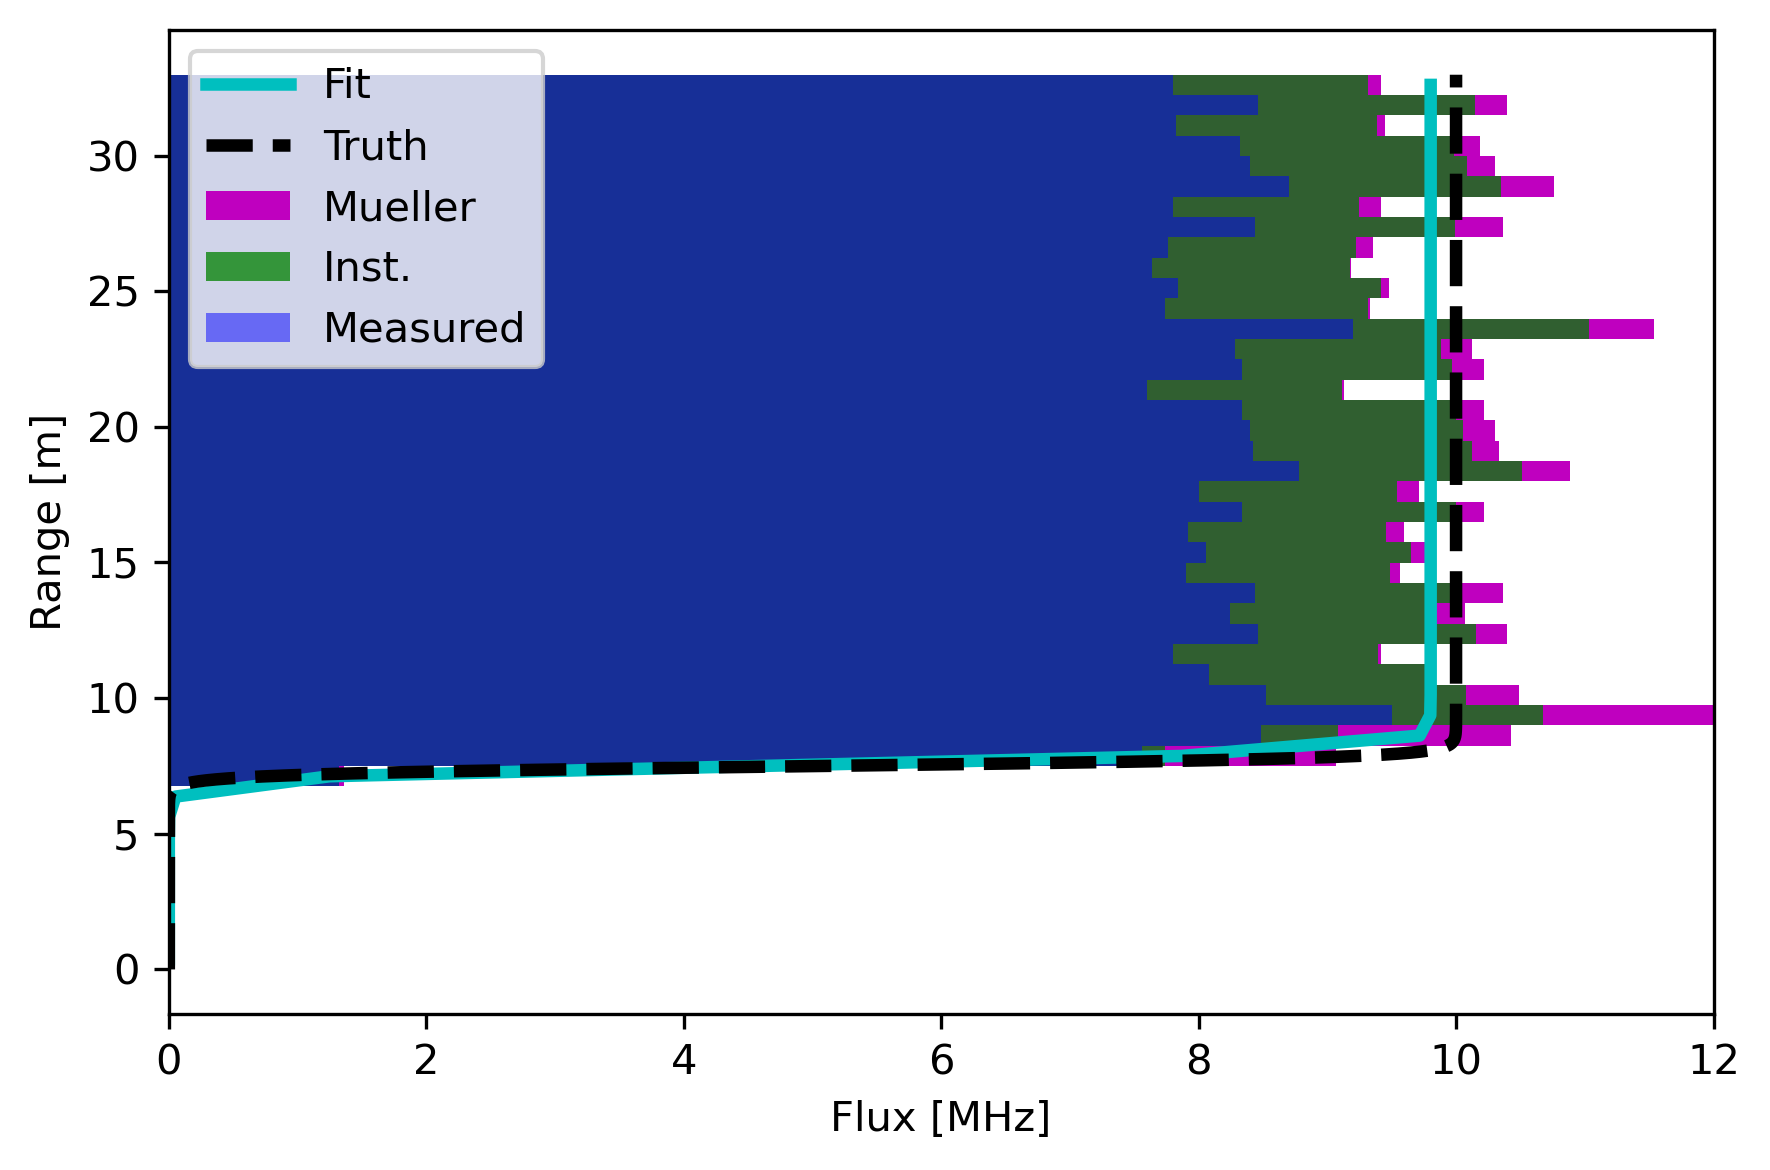

In [19]:
# Let's code up the instantaneous deadtime correction

Z = active_ratio_hst
Y = Y

dinst = Y/n_shots/binwidth/Z

bin_avg = dsamp  # integration factor (increase bin sizes)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)

# tof = (np.array(det_events)*dt_sim)
n, bins = np.histogram(flight_time, bins=AF_bin_edges)
N = n / binwidth / n_shots  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.barh(center*c/2, N/(1-N*dtime)/1e6, align='center', height=binwidth*c/2, color='m', alpha=1, label='Mueller')
ax.barh(center*c/2, dinst/1e6, align='center', height=binwidth*c/2, color='g', alpha=0.75, label='Inst.')
ax.barh(center*c/2, N/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.5, label='Measured')

ax.plot(pred.detach().numpy()/1e6, center*c/2, 'c', linewidth=3, label='Fit')

ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_xlim([0, 12])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Testing on a spatially variable feature

Recall that the Mueller Correction works well when observing uniform signals with coarse bins. The sigmoid test was an example of that. Let's do something a little more realistic, where the signal shape is narrow and high flux (like hitting the edge of a cloud). I already simulated this, I'll try pulling from those simulations already.

In [4]:
# load data from cloud edge simulations

# load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Cloud Measurements', 'Sims', 'saved_sims')
load_dir = os.path.join(home, 'OneDrive - UCB-O365', 'ARSENL', 'Experiments', 'Digitization Tests', 'Sims', 'saved_sims')
fname = 'cloud_simnum_6_nshot1.00E+04_useHGFalse_T0.05.nc'

ds = xr.open_dataset(os.path.join(load_dir, fname))

In [6]:
phot_events = ds.true_time_tag.values
dt_sim = ds.dt_sim.values
t_sim_bins = ds.t_sim_bins.values
Nshot_tot = ds.sync_index.values[-1] + 1
det_events = ds.time_tag.values
photon_rate_arr = ds.photon_rate_arr.values
dtime = ds.dtime.values
t_sim = t_sim_bins[:-1]

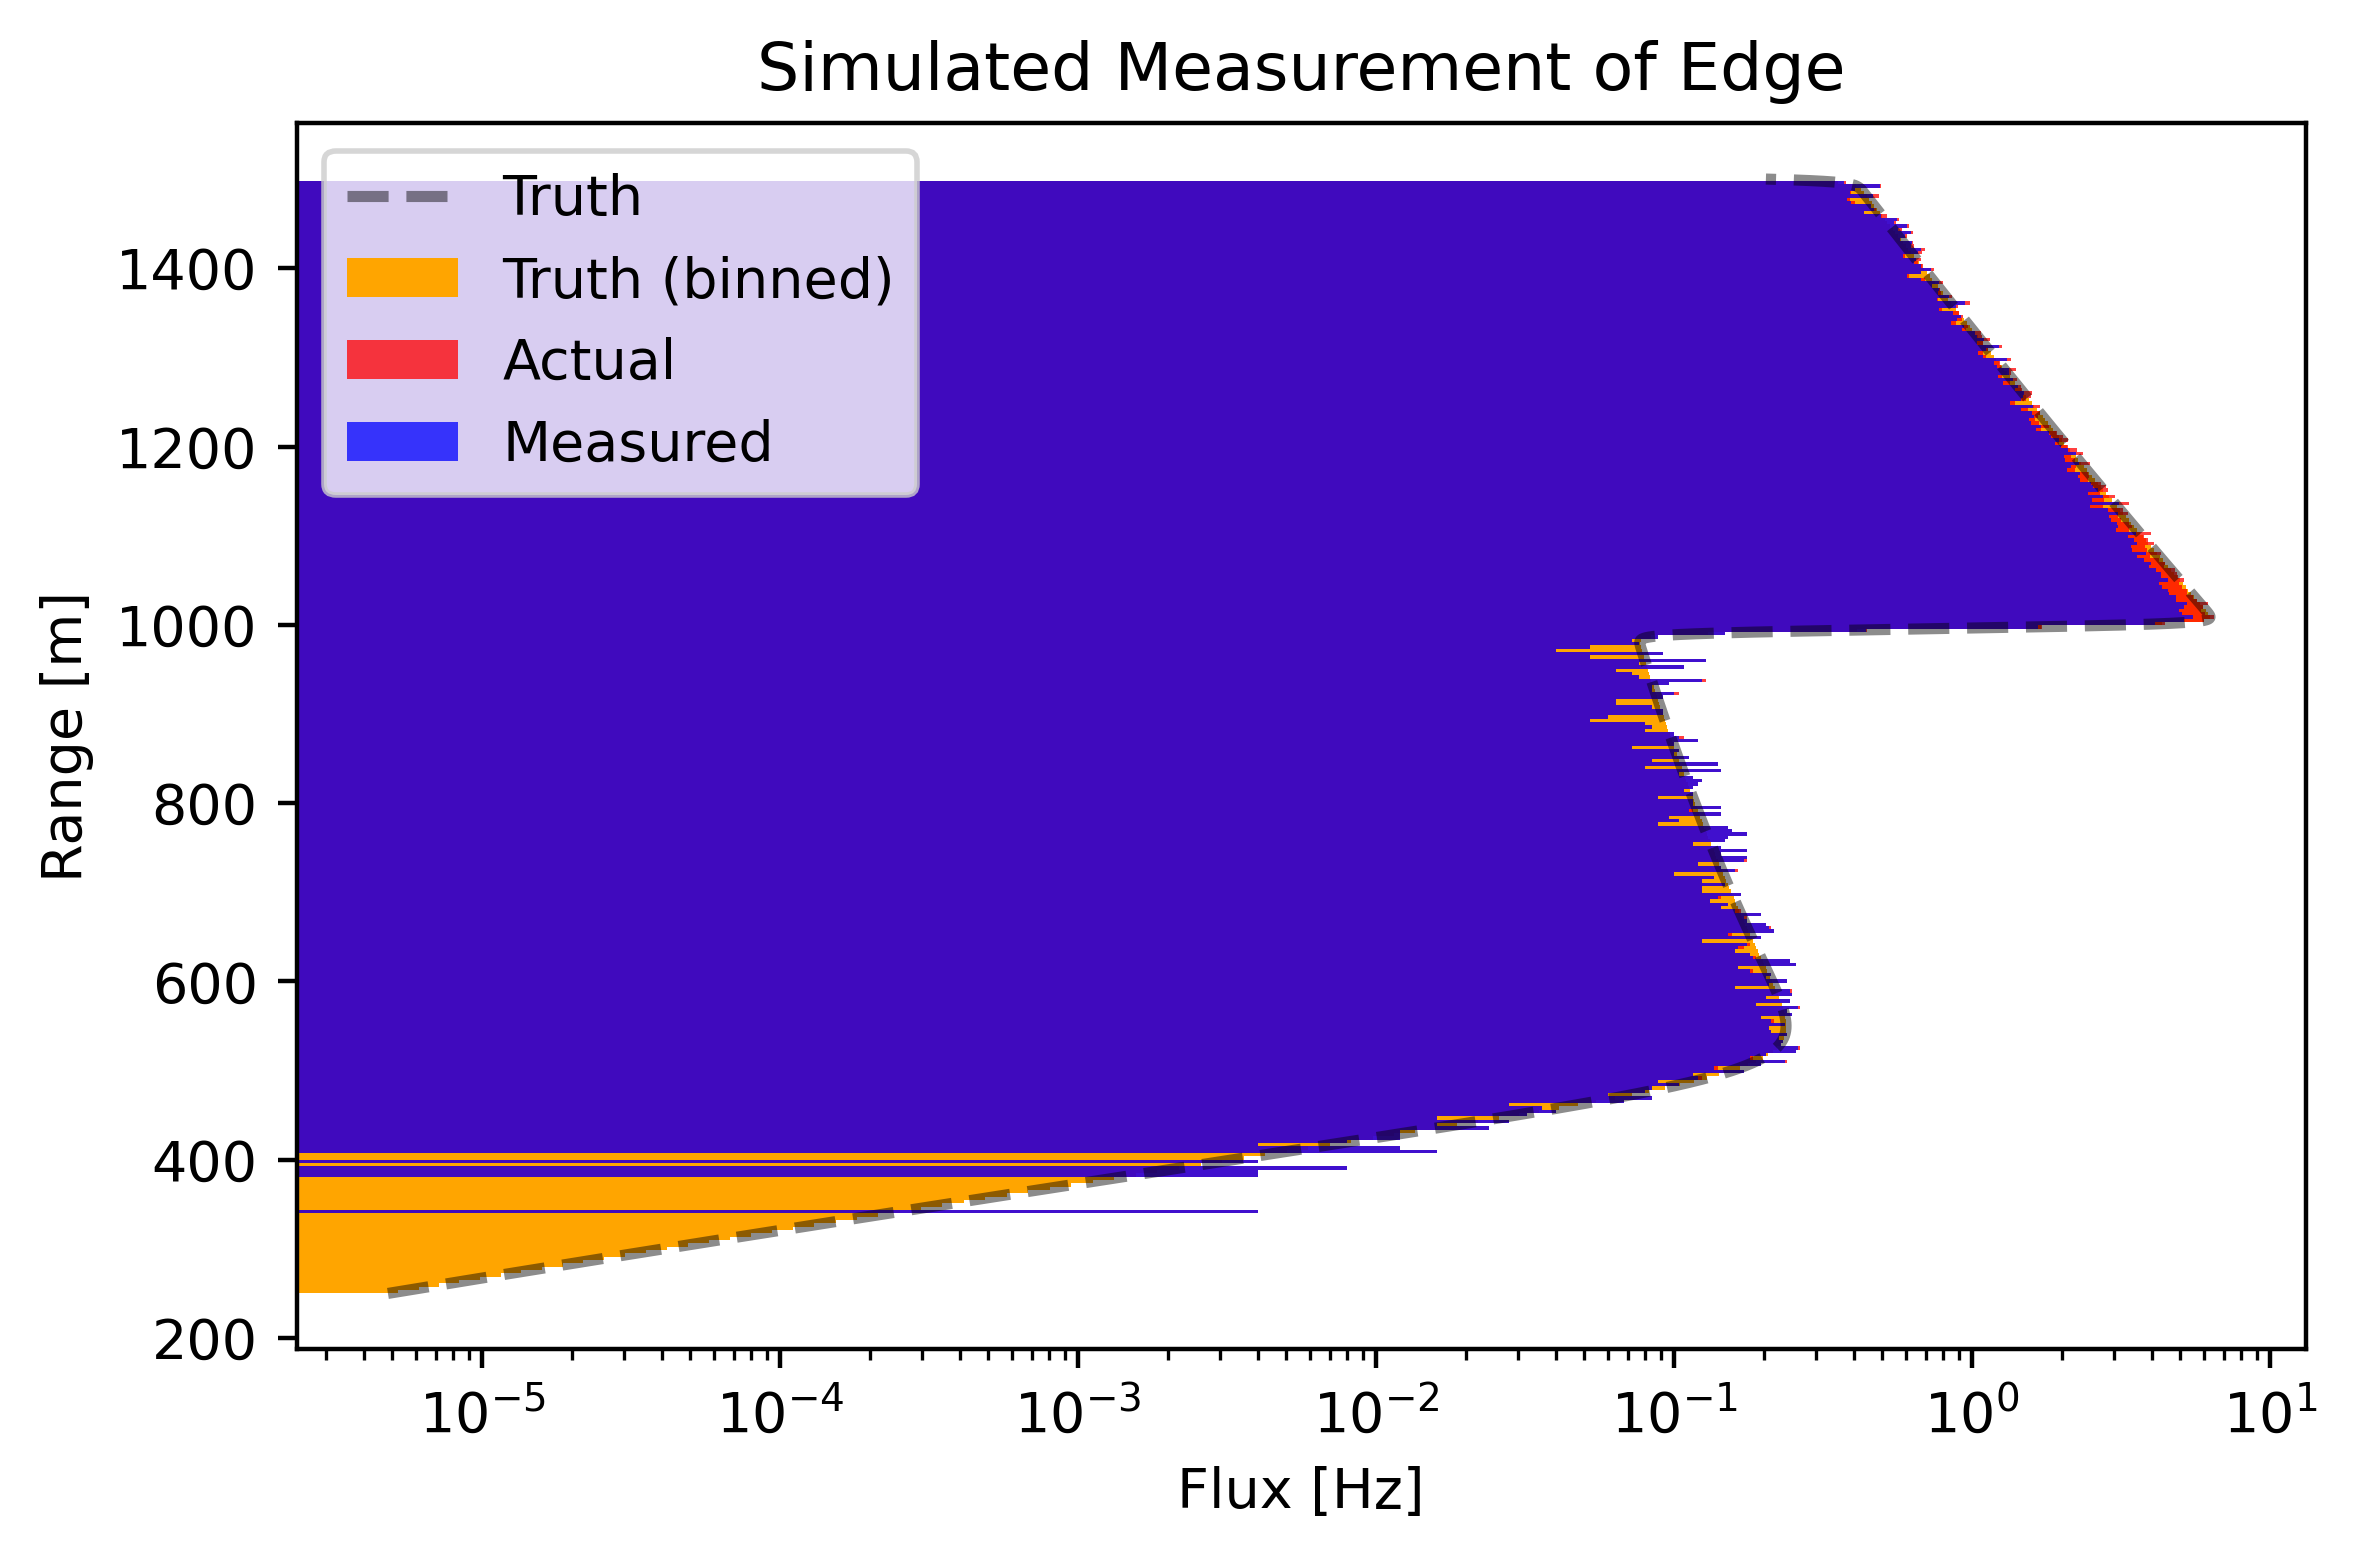

In [7]:
bin_avg = 1000  # integration factor (increase bin sizes)

photon_rate_arr_plt = photon_rate_arr[:len(photon_rate_arr)-len(photon_rate_arr)%bin_avg]
photon_rate_arr_plt = np.reshape(photon_rate_arr_plt, (len(photon_rate_arr)//bin_avg, bin_avg))
photon_rate_arr_plt = np.mean(photon_rate_arr_plt, axis=1)

fig = plt.figure(dpi=400)
ax = fig.add_subplot(111)

n, bins = np.histogram((np.array(phot_events)*dt_sim), bins=t_sim_bins[::bin_avg])
binwidth = np.diff(bins)[0]
N = n / binwidth / Nshot_tot  # [Hz]
center = 0.5 * (bins[:-1] + bins[1:])

ax.barh(center*c/2, photon_rate_arr_plt/1e6, align='center', height=binwidth*c/2, color='orange', alpha=1.0, label='Truth (binned)')
ax.barh(center*c/2, N/1e6, align='center', height=binwidth*c/2, color='r', alpha=0.75, label='Actual')

tof = (np.array(det_events)*dt_sim)
n, bins = np.histogram(tof, bins=t_sim_bins[::bin_avg])
N = n / binwidth / Nshot_tot  # [Hz] Scaling counts to arrival rate
ax.barh(center*c/2, N/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.75, label='Measured')

ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=0.45, linewidth=2, label='Truth')
# ax.plot(photon_rate_arr_plt/1e6, center*c/2, 'orange', marker='o', alpha=0.5, label='Truth (bin)')

ax.set_xlabel('Flux [Hz]')
ax.set_ylabel('Range [m]')
ax.set_title('Simulated Measurement of Edge')
ax.set_xscale('log')
plt.tight_layout()
plt.legend()
plt.show()

In [14]:
t_min = t_sim[0]  # [s]
t_max = t_sim[-1]  # [s]
window_bnd = [t_min, t_max]  # [s]
max_lsr_num = int(1e4)
exclude_shots = True
flight_time, n_shots, t_det_lst = dorg.data_organize(dt_sim, load_dir, fname, window_bnd, max_lsr_num-1, exclude_shots)
t_phot_fit_tnsr = torch.tensor(flight_time.values)

# calculate active fraction histogram
dsamp = 10
intgrl_N = int(len(t_sim_bins)/dsamp)  # number of bins in integral. I usually set this to the number of bins in the histogram for consistency
deadtime = dtime  # [s] 

active_ratio_hst, AF_bin_edges = fit.deadtime_noise_hist(t_min, t_max, intgrl_N, deadtime, t_det_lst, n_shots)
active_ratio_hst = active_ratio_hst.detach().numpy()
active_ratio_hst[np.where(active_ratio_hst==0)[0]] = sys.float_info.min  # if AF=0 for any bin, replace it with small positive value
t_bins = AF_bin_edges[:-1] + 0.5*np.diff(AF_bin_edges)[0]
binwidth = np.diff(AF_bin_edges)[0]

Y = np.histogram(t_phot_fit_tnsr.detach().numpy(), bins=AF_bin_edges)[0]

# t_intgrl = torch.arange(t_min, t_max, binwidth)[:-1]  # [s]
t_intgrl = torch.tensor(t_bins)  # [s]

print('Acquisition binwidth: {:.2E}'.format(binwidth))

Acquisition binwidth: 2.50E-10


In [15]:
# Let's apply the Mueller and Inst. Deadtime Corrections to the profiles

muller = (1/n_shots/binwidth) * Y/(1-Y/n_shots/binwidth*dtime)  # [Hz]
dinst = (1/n_shots/binwidth) * Y/active_ratio_hst  # [Hz]
raw = (1/n_shots/binwidth) * Y  # [Hz]

dinst[np.where(dinst==np.inf)[0]] = np.nan  # if inf value, set to highest number instead

bins = AF_bin_edges
center = 0.5 * (bins[:-1] + bins[1:])

# raw[raw==0] = np.nan
# dinst[dinst==0] = np.nan
# muller[muller==0] = np.nan

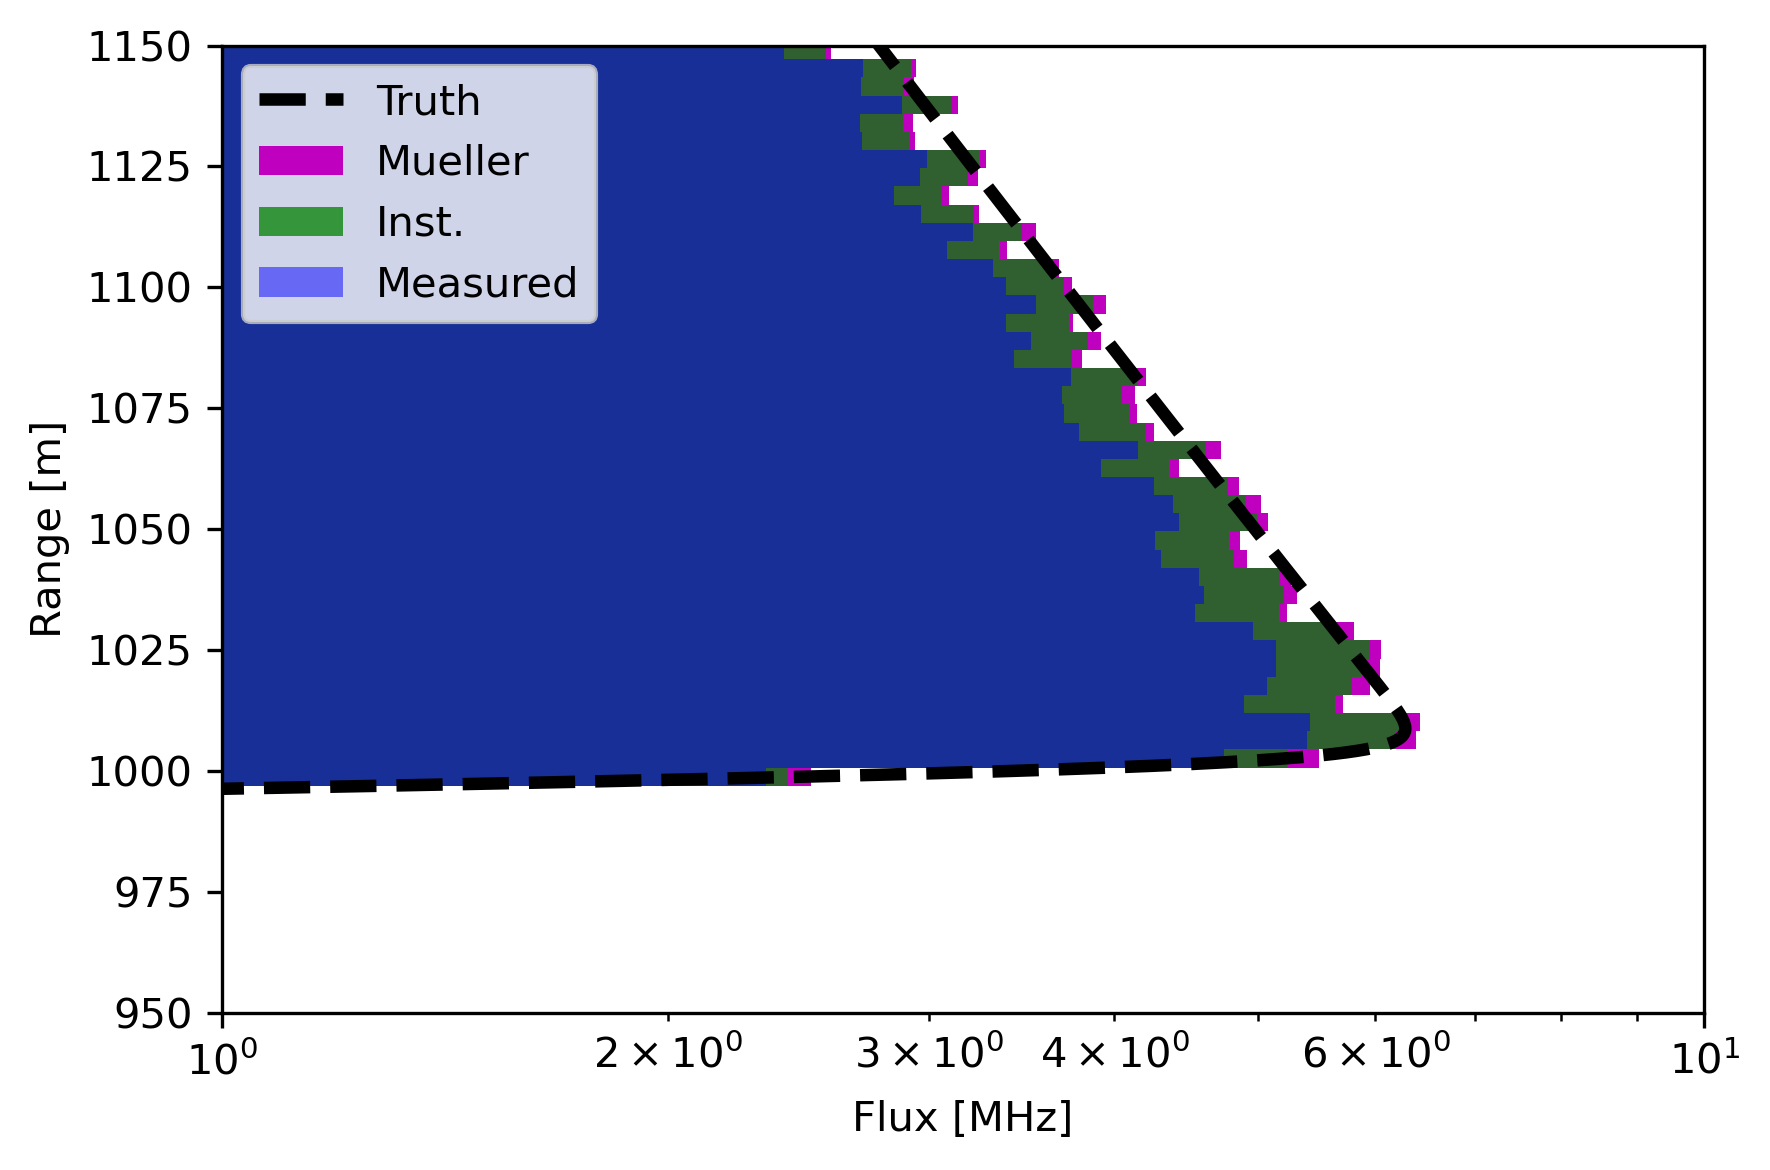

In [13]:
if binwidth<=100e-12:
    print('Restarting kernel b/c plotting would have taken too long...')
    quit()

fig = plt.figure(dpi=300, facecolor='w')
ax = fig.add_subplot(111)

ax.barh(center*c/2, muller/1e6, align='center', height=binwidth*c/2, color='m', alpha=1, label='Mueller')
ax.barh(center*c/2, dinst/1e6, align='center', height=binwidth*c/2, color='g', alpha=0.75, label='Inst.')
ax.barh(center*c/2, raw/1e6, align='center', height=binwidth*c/2, color='b', alpha=0.5, label='Measured')

ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')

ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_xlim([1, 10])
ax.set_ylim([950, 1150])
ax.set_xscale('log')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [19]:
avg_bins = 1000
binwidth_smooth = binwidth * avg_bins

max_idx = (len(raw)//avg_bins) * avg_bins
rmndr = len(raw) - max_idx  # remainder to discard (make sure this is a small number)
print('Remainder bins getting thrown away to average to coarser bins: {}'.format(rmndr))

# Raw counts
raw_reshape = np.reshape(raw[:max_idx], (len(raw)//avg_bins, avg_bins))
raw_smooth = np.sum(raw_reshape, axis=1) / avg_bins
# Instantaneous correction applied before averaging to coarser bins
dinst_reshape = np.reshape(dinst[:max_idx], (len(dinst)//avg_bins, avg_bins))
dinst_smooth = np.nansum(dinst_reshape, axis=1) / avg_bins

# Muller correction applied BEFORE averaging to coarser bins
muller_reshape = np.reshape(muller[:max_idx], (len(muller)//avg_bins, avg_bins))
muller_smooth = np.sum(muller_reshape, axis=1) / avg_bins
# Muller correction applied AFTER averaging to coarser bins
Y_reshape = np.reshape(Y[:max_idx], (len(Y)//avg_bins, avg_bins))
Y_smooth = np.sum(Y_reshape, axis=1) / avg_bins
muller_coarse = (1/n_shots/binwidth) * Y_smooth/(1-Y_smooth/n_shots/binwidth*dtime)

# Also do this for the truth curve
tot_avg_bins = avg_bins * dsamp
truth_max_idx = (len(photon_rate_arr)//tot_avg_bins) * tot_avg_bins
truth_reshape = np.reshape(photon_rate_arr[:truth_max_idx], (len(photon_rate_arr)//tot_avg_bins, tot_avg_bins))
truth_smooth = np.sum(truth_reshape, axis=1) / tot_avg_bins

center_smooth = center[:max_idx][np.floor(avg_bins/2).astype(int)::avg_bins]

print('Smoothed Binwidth: {:.2E}'.format(binwidth_smooth))

Remainder bins getting thrown away to average to coarser bins: 356
Smoothed Binwidth: 2.50E-07


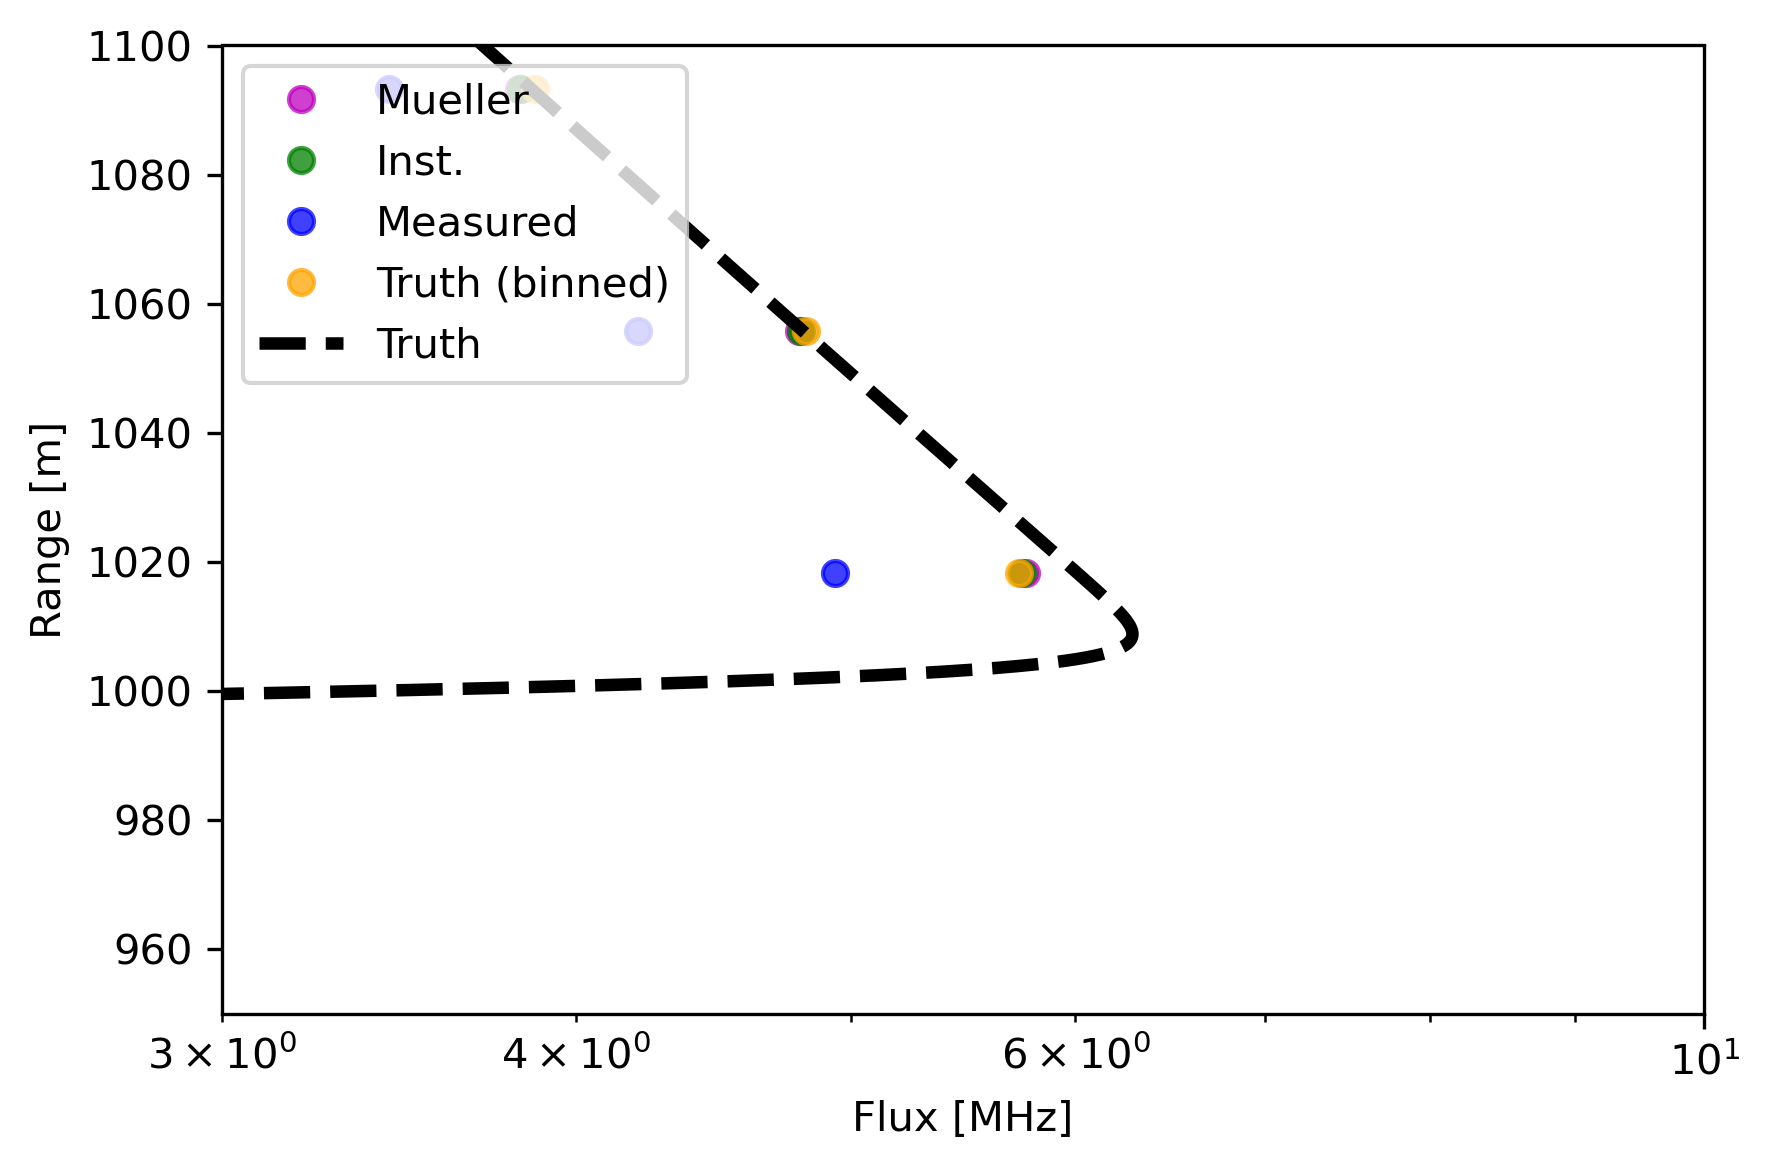

In [22]:
fig = plt.figure(dpi=300, facecolor='w')
ax = fig.add_subplot(111)

# # ax.barh(center_smooth*c/2, muller_smooth/1e6, align='center', height=binwidth_smooth*c/2, color='m', alpha=1, label='Mueller')
# ax.barh(center_smooth*c/2, muller_coarse/1e6, align='center', height=binwidth_smooth*c/2, color='m', alpha=1.0, label='Muller')
# ax.barh(center_smooth*c/2, dinst_smooth/1e6, align='center', height=binwidth_smooth*c/2, color='g', alpha=0.75, label='Inst.')
# ax.barh(center_smooth*c/2, raw_smooth/1e6, align='center', height=binwidth_smooth*c/2, color='b', alpha=0.5, label='Measured')
ax.plot(muller_coarse/1e6, center_smooth*c/2, 'o', color='m', alpha=0.75, label='Mueller')
ax.plot(dinst_smooth/1e6, center_smooth*c/2, 'o', color='g', alpha=0.75, label='Inst.')
ax.plot(raw_smooth/1e6, center_smooth*c/2, 'o', color='b', alpha=0.75, label='Measured')
ax.plot(truth_smooth/1e6, center_smooth*c/2, 'o', color='orange', alpha=0.75, label='Truth (binned)')

ax.plot(photon_rate_arr/1e6, t_sim*c/2, 'k--', alpha=1.0, linewidth=3, label='Truth')
ax.set_ylabel('Range [m]')
ax.set_xlabel('Flux [MHz]')
ax.set_xscale('log')
ax.set_xlim([3, 10])
ax.set_ylim([950, 1100])
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# calculated errors

phot_rate_centered = photon_rate_arr[int(dsamp/2)::dsamp][:-1]

err_raw = np.abs(raw - phot_rate_centered)
err_muller = np.abs(muller - phot_rate_centered)
err_dinst = np.abs(dinst - phot_rate_centered)

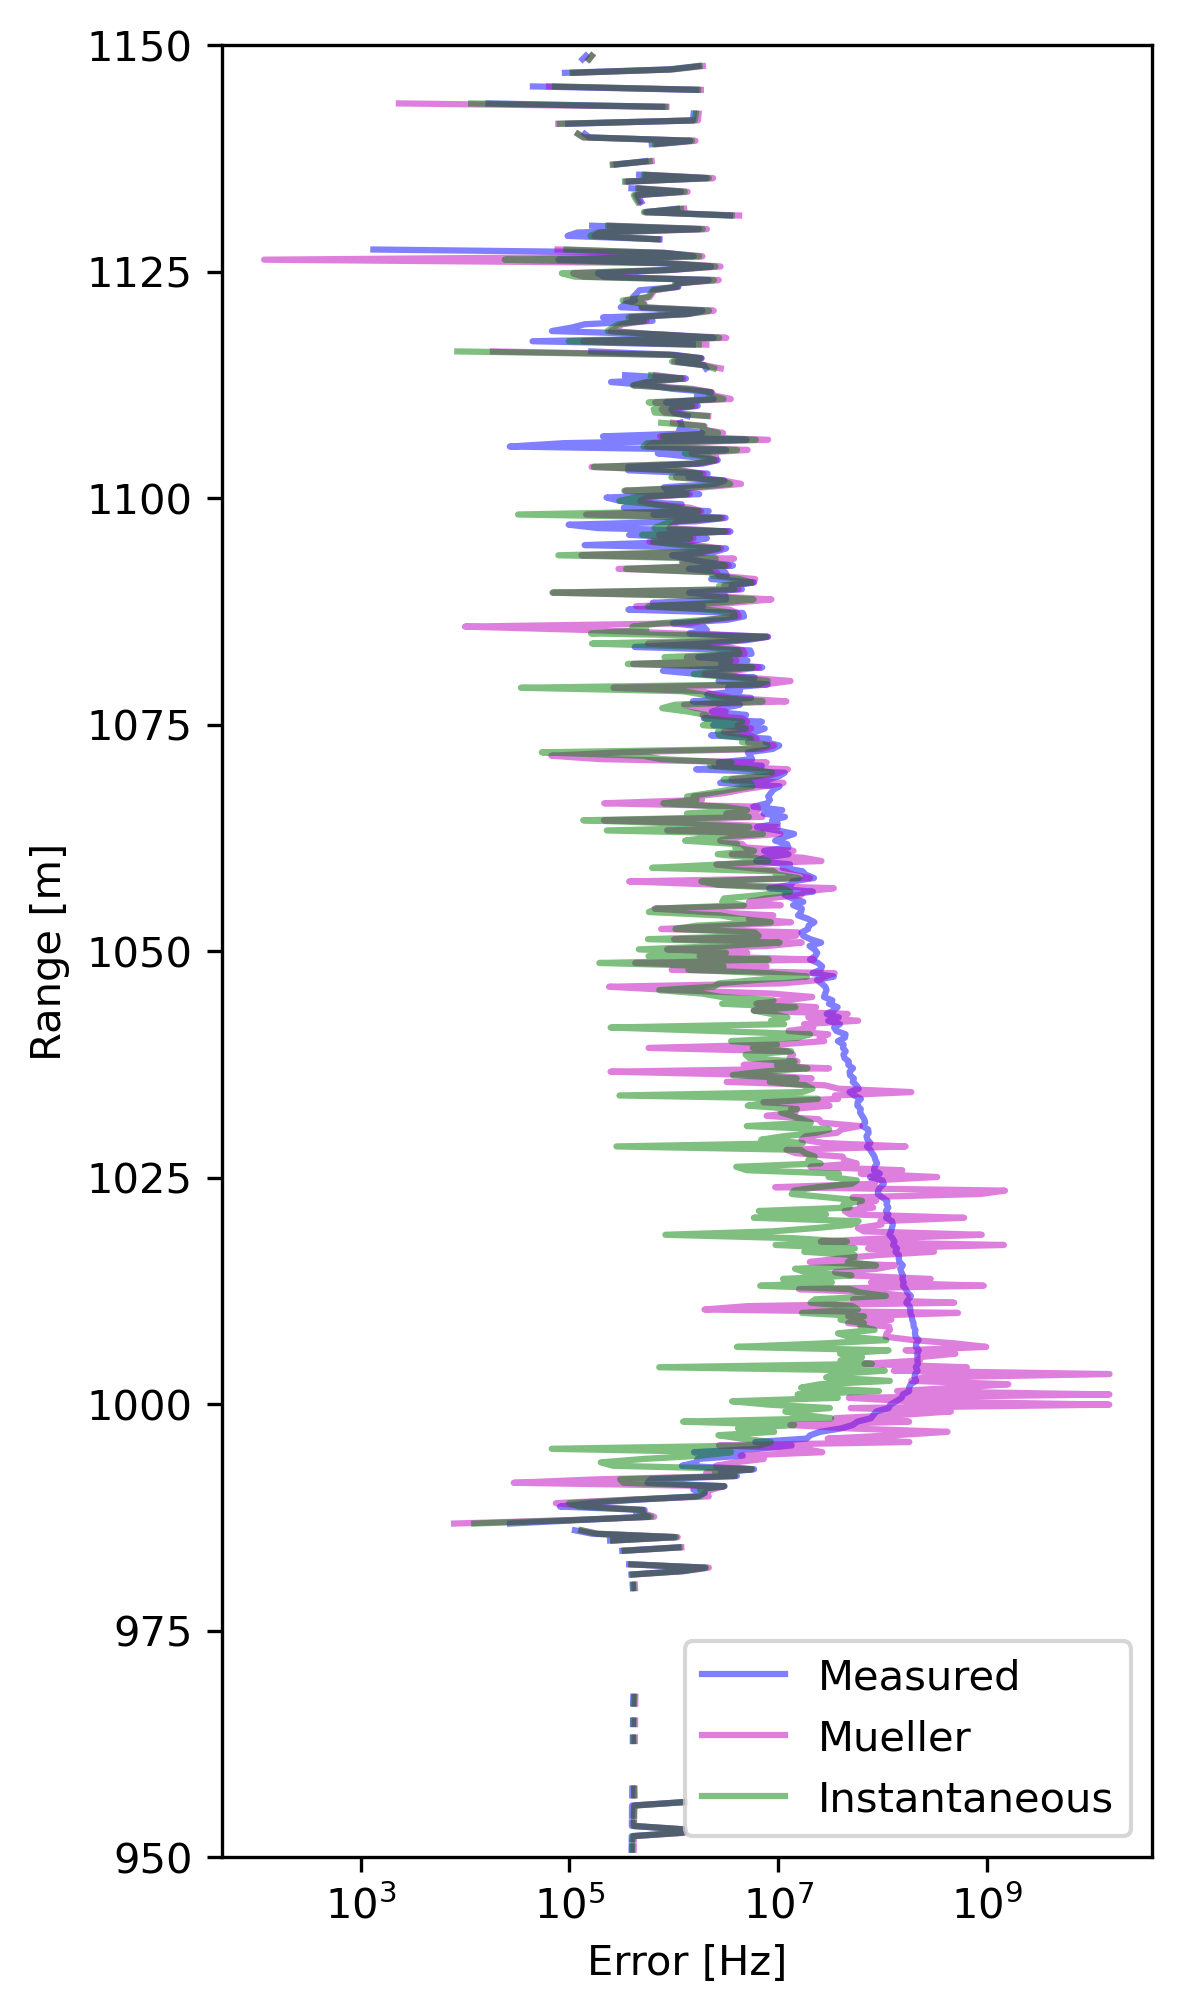

In [37]:
# Plot error profile

fig = plt.figure(dpi=300, figsize=(4,8))
ax = fig.add_subplot(111)
ax.plot(err_raw, center*c/2, 'b-', alpha=0.5, label='Measured')
ax.plot(err_muller, center*c/2, 'm-', alpha=0.5, label='Mueller')
ax.plot(err_dinst, center*c/2, 'g-', alpha=0.5, label='Instantaneous')
ax.set_xlabel('Error [Hz]')
ax.set_ylabel('Range [m]')
ax.set_ylim([950, 1150])
ax.set_xscale('log')
plt.legend()
plt.show()